# Train/Eval split by month (April?June train)
Loading the full dataset and creating train/eval pandas DataFrames.

In [12]:
import pandas as pd
from pathlib import Path

data_path = Path('Data/bank-additional-full.csv')
df = pd.read_csv(data_path, sep=';')
df.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [32]:
train_months = {'apr', 'may', 'jun', 'jul', 'aug'}
mask = df['month'].str.lower().isin(train_months)
train_df = df[mask].copy()
eval_df = df[~mask].copy()

print(f'Train rows: {len(train_df)}  Eval rows: {len(eval_df)}')
print('Train y counts: ', train_df['y'].value_counts())
print('Eval y counts: ', eval_df['y'].value_counts())


Train rows: 35071  Eval rows: 6117
Train y counts:  y
no     31783
yes     3288
Name: count, dtype: int64
Eval y counts:  y
no     4765
yes    1352
Name: count, dtype: int64


In [33]:
# Month breakdowns to verify split boundary
print('Train months:')
display(train_df['month'].value_counts())
print('Eval months:')
display(eval_df['month'].value_counts())


Train months:


month
may    13769
jul     7174
aug     6178
jun     5318
apr     2632
Name: count, dtype: int64

Eval months:


month
nov    4101
oct     718
sep     570
mar     546
dec     182
Name: count, dtype: int64

## Model: predict high vs low response
Using logistic regression with one-hot encoding to classify clients as high-response (`yes`) or low-response (`no`).


In [34]:
# Prepare features/target
target_map = {'yes': 1, 'no': 0}
y_train = train_df['y'].map(target_map)
y_eval = eval_df['y'].map(target_map)

X_train = train_df.drop(columns=['y'])
X_eval = eval_df.drop(columns=['y'])

cat_cols = [c for c in X_train.columns if X_train[c].dtype == 'object']
num_cols = [c for c in X_train.columns if X_train[c].dtype != 'object']
print(f"Categorical cols: {len(cat_cols)}  Numeric cols: {len(num_cols)}")
for n in num_cols:
    print(n)
print("Categorical cols:")
for c in cat_cols:
    print(c)

Categorical cols: 10  Numeric cols: 10
age
duration
campaign
pdays
previous
emp.var.rate
cons.price.idx
cons.conf.idx
euribor3m
nr.employed
Categorical cols:
job
marital
education
default
housing
loan
contact
month
day_of_week
poutcome


In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

preprocess = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('numeric', 'passthrough', num_cols),
    ],
    remainder='drop'
)

clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LogisticRegression(max_iter=500, class_weight='balanced', n_jobs=-1)),
])
clf


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('categorical', ...), ('numeric', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [36]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

clf.fit(X_train, y_train)

eval_pred = clf.predict(X_eval)
eval_proba = clf.predict_proba(X_eval)[:, 1]

print(f'Eval ROC-AUC: {roc_auc_score(y_eval, eval_proba):.3f}')
print('Classification report (eval):')
print(classification_report(y_eval, eval_pred, target_names=['low-response', 'high-response']))

cm = pd.DataFrame(
    confusion_matrix(y_eval, eval_pred),
    index=['true low', 'true high'],
    columns=['pred low', 'pred high'],
)
cm


Eval ROC-AUC: 0.872
Classification report (eval):
               precision    recall  f1-score   support

 low-response       0.96      0.70      0.81      4765
high-response       0.46      0.89      0.60      1352

     accuracy                           0.74      6117
    macro avg       0.71      0.79      0.71      6117
 weighted avg       0.85      0.74      0.76      6117



,pred low,pred high
true low,3341,1424
true high,155,1197


In [37]:
# Score the eval set to prioritize calls
scored_eval = eval_df.copy()
scored_eval['high_response_score'] = eval_proba
scored_eval[['high_response_score', 'y']].describe()


,high_response_score
count,6117.000000
mean,0.440322
std,0.390534
min,0.008344
25%,0.063990
50%,0.260525
75%,0.883353
max,1.000000


In [ ]:
# Top 5 likely responders
scored_eval.sort_values('high_response_score', ascending=False)[['high_response_score', 'y', 'job', 'education', 'contact']]


# create a GUI that lets people input features and get a prediction from the model


,high_response_score,y,job,education,contact
24091,1.000000,no,technician,professional.course,telephone
27833,1.000000,yes,self-employed,university.degree,cellular
24043,1.000000,no,blue-collar,professional.course,telephone
24004,1.000000,no,admin.,high.school,telephone
39171,1.000000,yes,admin.,university.degree,cellular
...,...,...,...,...,...
27193,0.010741,no,blue-collar,basic.9y,cellular
26636,0.010565,no,technician,basic.6y,telephone
27681,0.008738,no,housemaid,basic.4y,telephone
27194,0.008635,no,services,high.school,telephone


c:\Users\furqa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


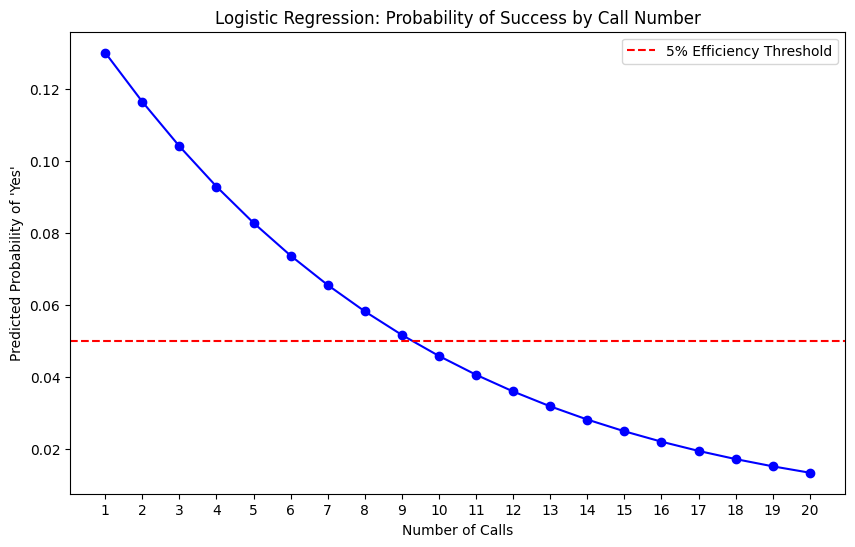

Recommendation: Stop calling after 9 attempts.


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# 1. Prepare Data
# Convert 'y' to 0 and 1
df['target'] = df['y'].map({'no': 0, 'yes': 1})

X = df[['campaign']]  # Feature: Number of calls
y = df['target']      # Target: 0 or 1

# 2. Fit Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X, y)

# 3. Simulate Call Numbers 1 through 20 to see the trend
calls_range = np.arange(1, 21).reshape(-1, 1)
# predict_proba returns [Prob_0, Prob_1]. We want Prob_1 (Success)
probs = log_reg.predict_proba(calls_range)[:, 1]

# 4. Visualize & Analyze
plt.figure(figsize=(10, 6))
plt.plot(calls_range, probs, marker='o', linestyle='-', color='blue')
plt.axhline(y=0.05, color='r', linestyle='--', label='5% Efficiency Threshold') # Business logic line
plt.title("Logistic Regression: Probability of Success by Call Number")
plt.xlabel("Number of Calls")
plt.ylabel("Predicted Probability of 'Yes'")
plt.xticks(range(1, 21))
plt.legend()
plt.show()

# 5. Answer the Question
# Find the first call number where probability drops below 5% (0.05)
threshold = 0.05
drop_off_point = calls_range[probs < threshold][0][0]
print(f"Recommendation: Stop calling after {drop_off_point - 1} attempts.")

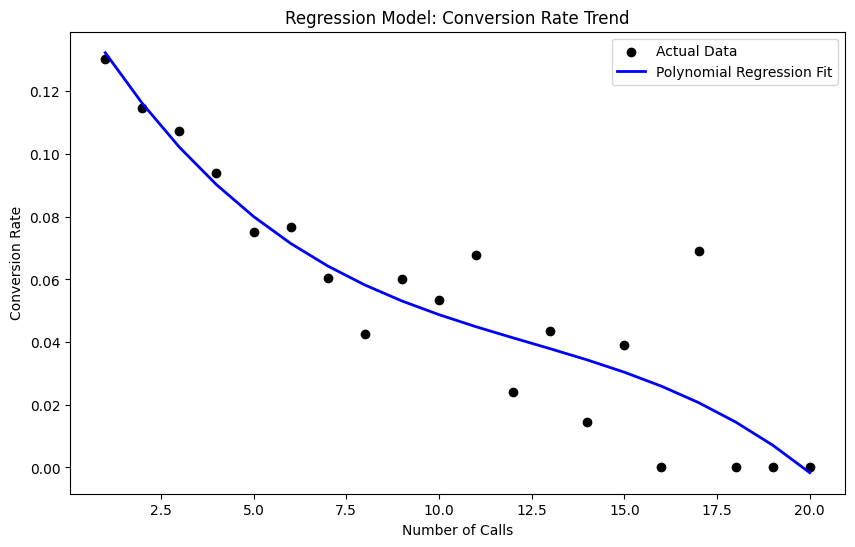

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# 1. Aggregate Data (Create a mini dataset of Call Count vs Conversion Rate)
agg_data = df.groupby('campaign')['target'].mean().reset_index()
agg_data.columns = ['campaign', 'conversion_rate']

# Limit to first 20 calls (outliers skew regression)
agg_data = agg_data[agg_data['campaign'] <= 20]

X_agg = agg_data[['campaign']]
y_agg = agg_data['conversion_rate']

# 2. Polynomial Transformation (Degree 2 or 3 to allow a curve)
poly = PolynomialFeatures(degree=3) 
X_poly = poly.fit_transform(X_agg)

# 3. Fit Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y_agg)

# 4. Predict Trend
y_pred = lin_reg.predict(X_poly)

# 5. Visualize
plt.figure(figsize=(10, 6))
plt.scatter(X_agg, y_agg, color='black', label='Actual Data')
plt.plot(X_agg, y_pred, color='blue', linewidth=2, label='Polynomial Regression Fit')
plt.title("Regression Model: Conversion Rate Trend")
plt.xlabel("Number of Calls")
plt.ylabel("Conversion Rate")
plt.legend()
plt.show()

# Insight: Look at the peak of the blue line. 
# That is the "average number of calls for maximum success."